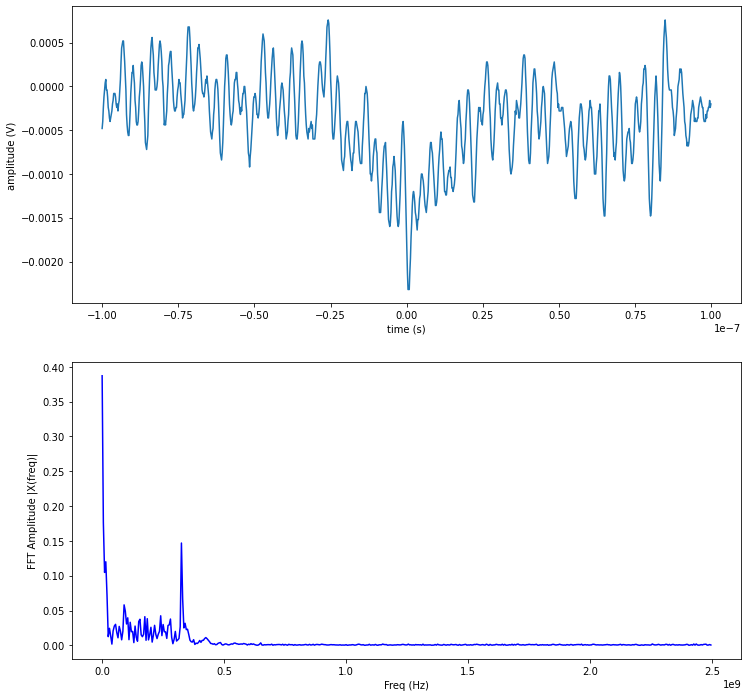

In [1]:
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

class ScopeWaveform:
    def __init__(self, infpn):
        columns = ['info_name', 'value', 'units', 'time', 'waveform_value']
        self.df = pd.read_csv(infpn, names=columns)

        # add a partial sum column
        self.waveform_partial_integral()
    
    def waveform_partial_integral(self):
        '''
        Partial sum of the waveform to study the pulse area.
        '''
        self.df['partial_integral'] = self.df.waveform_value.cumsum()
    
    def waveform_fft(self):
        '''
        Ref: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
        '''
        X = fft(self.df.waveform_value.values)
        N = len(X)
        n = np.arange(N)
        # get the sampling rate
        sr = 1 / 2e-10
        T = N/sr
        freq = n/T

        # Get the one-sided specturm
        n_oneside = N//2
        # get the one side frequency
        f_oneside = freq[:n_oneside]

        # first, plot the original signal
        _, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
        ax1.plot(self.df.time, self.df.waveform_value)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('amplitude (V)')

        ax2.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
        ax2.set_xlabel('Freq (Hz)')
        ax2.set_ylabel('FFT Amplitude |X(freq)|')
        
        plt.show()

wf1 = ScopeWaveform('data/220207_135934_inverter_noise_1000.csv')
wf1.waveform_fft()

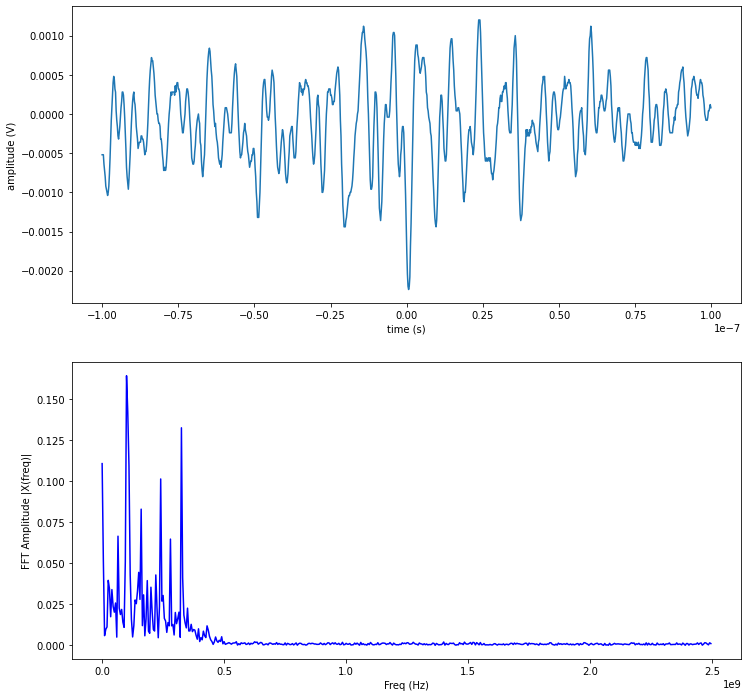

In [2]:
wf2 = ScopeWaveform('data/220207_140238_inverter_noise_2000.csv')
wf2.waveform_fft()